# How to start writing a calibration notebook

Author: European XFEL Detector Group, Version 0.1

This is an example notebook to point to some common practices used in production notebooks.
This notebook is using ePix100 detector RAW data to apply offset and gain correction

This is meant to be a starting point on how to write calibration notebooks that can run in production using
`xfel-calibrate` CLI. However, it is recommended to have a look on some production notebooks residing
in `/notebooks/` directory which can have more advanced practices that can help you during your notebook development.

In [1]:
# This first code cell must always contain the global notebook parameters.
# The parameters are parsed as input arguments for `xfel-calibration` command line interface.
# It is very important to have a comment for each parameter. The comments are not only helpful within the notebook,
# but they are used the as parameter description when `xfel-calibrate DETECTOR CALIBRATION --help` is used.

in_folder = "/gpfs/exfel/exp/CALLAB/202130/p900203/raw/"  # directory to read data from, required
out_folder = "/gpfs/exfel/exp/CALLAB/202130/p900203/scratch/how_write_xfel_calibrate_NBC"  # directory to output to, required
# Adding `required` at the comment here forces the user to add the parameter through the command line,
# ignoring the default value and only using it as an indication of the expected type.
run = 9046  # runs to process, required

# Parameters for accessing the raw data.
karabo_da = "EPIX01"  # Data aggregator names. For multi-modular detectors like AGIPD and LPD, this is a list.
# To access the correct data files and calibration constants. The karabo_id string is used as a detector identifier.
karabo_id = "HED_IA1_EPX100-1"  # Detector karabo_id name

# Boolean parameter can be set to False from xfel-calibrate by adding `no-` at the beginning of the boolean parameter name.
gain_correction = True  # Proceed with gain correction.

# Parameters for the calibration database.
creation_time = ""  # The timestamp to use with Calibration DB. Required Format: "YYYY-MM-DD hh:mm:ss" e.g. 2019-07-04 11:02:41
# It is preferred if operating conditions are read from RAW data instead of passed as an input argument.
bias_voltage = 200  # RAW data bias voltage.
in_vacuum = False  # Detector operated in vacuum
photon_energy = 8.048  # Photon energy used for gain calibration
fix_temperature = 290  # fixed temperature value in Kelvin.

# Parameters affecting writing corrected data.
chunk_size_idim = 1  # H5 chunking size of output data

In [2]:
from pathlib import Path

# Write after the first python notebook cell. It is a good practice to import all needed libraries and modules.
# Same as we do in a normal python module.
import matplotlib.pyplot as plt

import numpy as np

# To access data `extra_data` is used to read RAW/CORR data.
from extra_data import RunDirectory  # https://extra-data.readthedocs.io/en/latest/

from extra_geom import Epix100Geometry  # https://extra-geom.readthedocs.io/en/latest/

# For parallelization with a notebook it is suggested to use multiprocessing.
import multiprocessing  # or
import pasha as psh # https://github.com/European-XFEL/pasha
# This library uses multiprocessing and provide tight integration with extra_data

# `cal_tools` directory consists of multiple useful functions that are used in many notebooks.
import cal_tools.restful_config as rest_cfg
# `calcat_interface` is the main module with functions to retrieve calibration constants from CALCAT.
from cal_tools.calcat_interface import EPIX100_CalibrationData
from cal_tools.epix100 import epix100lib
# `cal_tools.files` is recommended to write corrected data.
from cal_tools.files import DataFile
# An internal class to record computation time.
from cal_tools.step_timing import StepTimer
# `tools` consists for various number of functions to read files, wrappers for iCalibrationDB, etc ...
from cal_tools.tools import (
    calcat_creation_time,
)

## Prepare global variables.

In the following cells it is a common practice to start assigning global variables,
like converting in_folder and out_folder to Path objects or initializing step_timer object.

In [3]:
# Convert main folders to Paths.
in_folder = Path(in_folder)
out_folder = Path(out_folder)
# This is only needed in case of running the notebook interactively. Otherwise, the machinery take care of this.
out_folder.mkdir(parents=True, exist_ok=True)
run_folder = in_folder / f"r{run:04d}"

# Initiate the main Run data collection.
run_dc = RunDirectory(
    run_folder, include="*S00000*").select(f"*{karabo_id}*", require_all=True)

print(f"The available source to correct for {karabo_id} are {list(run_dc.all_sources)}")

step_timer = StepTimer()

The available source to correct for HED_IA1_EPX100-1 are ['HED_IA1_EPX100-1/DET/CONTROL', 'HED_IA1_EPX100-1/DET/RECEIVER', 'HED_IA1_EPX100-1/DET/RECEIVER:daqOutput']


## Read operating conditions from RAW data.

It is recommended to read the calibration constants' operating conditions directly from RAW data.
To avoid wrong given values from the notebook's input argument.
Unfortunately, there is the possibility that these conditions are not stored in RAW data
because the detector is in its early operation stages.


Below we give an example of reading the integration time of the data. There are multiple functions and similar class
as epix100Ctrl for other detectors that are used for the same purpose. 

In [4]:
# Read control data.
data_source = "HED_IA1_EPX100-1/DET/RECEIVER:daqOutput"

ctrl_data = epix100lib.epix100Ctrl(
    run_dc=run_dc,
    instrument_src=data_source,
    ctrl_src=f"{karabo_id}/DET/CONTROL",
    )

integration_time = ctrl_data.get_integration_time()

## Retrieve needed calibration constants

Usually there is a cell when we retrieve calibration constants before correction
and sometimes before processing new calibration constants.

In this example we use `EPIX100_CalibrationData` class to initialize an object with
the necessary operating conditions and creation time.

Below the operating conditions values like integration_time and sensor_temperature are hard coded to specific value.
In production notebooks this is done differently.

In [5]:
# Run creation time is important to get the correct calibration constant versions.
creation_time = calcat_creation_time(in_folder, run, creation_time)
print(f"Using {creation_time.isoformat()} as creation time")

epix_cal = EPIX100_CalibrationData(
    detector_name=karabo_id,
    sensor_bias_voltage=bias_voltage,
    integration_time=integration_time,
    sensor_temperature=fix_temperature,
    in_vacuum=in_vacuum,
    source_energy=photon_energy,
    event_at=creation_time,
    client=rest_cfg.calibration_client(),
)

const_data = epix_cal.ndarray_map()[karabo_da]

print(f"Retrieved calibrations for {karabo_id}: {list(const_data.keys())}")

Reading creation_date from input files metadata `INDEX/timestamp`
Using 2021-09-19T14:39:26.744069+00:00 as creation time
Retrieved calibrations for HED_IA1_EPX100-1: ['BadPixelsDarkEPix100', 'NoiseEPix100', 'OffsetEPix100', 'RelativeGainEPix100']


## Correcting Raw data

In [6]:
data_key = "data.image.pixels"
raw_data = run_dc[data_source, data_key].ndarray()
dshape = raw_data.shape  # Raw input data shape.

print(f"Number of trains to correct is {len(run_dc.train_ids)}")

def correct_train(wid, index, d):
    """Correct one train for ePix100 detector."""
    d -= const_data["OffsetEPix100"][..., 0]
    if gain_correction:
        d /= const_data["RelativeGainEPix100"]

step_timer.start()
context = psh.context.ThreadContext(num_workers=10)
corr_data = context.alloc(shape=dshape, dtype=np.float32)

context.map(correct_train, raw_data.astype(np.float32))
step_timer.done_step('Correcting data')

Number of trains to correct is 1000
Correcting data: 0.4 s


## Writing corrected data

In [7]:
# Storing data.
out_file = out_folder / "CORR-R9046-EPIX01-S00000.h5"
instrument_source = "HED_IA1_EPX100-1/DET/RECEIVER:daqOutput"

image_counts = run_dc[instrument_source, "data.image.pixels"].data_counts(labelled=False)

step_timer.start()
raw_file = run_dc.files[0]  # FileAccess object
with DataFile(out_file, "w") as ofile:
    # Create INDEX datasets.
    ofile.create_index(run_dc.train_ids, from_file=raw_file)

    # Create METDATA datasets
    ofile.create_metadata(
        like=run_dc,
        sequence=raw_file.sequence,
        instrument_channels=(f"{instrument_source}/data",)
    )
    # Create Instrument section to later add corrected datasets.
    outp_source = ofile.create_instrument_source(instrument_source)

    # Create count/first datasets at INDEX source.
    outp_source.create_index(data=image_counts)

    # Add main corrected `data.image.pixels` dataset and store corrected data.
    outp_source.create_key(
        "data.image.pixels", data=corr_data, chunks=((chunk_size_idim,) + dshape[1:]))
step_timer.done_step('Writing corrected data')

Writing corrected data: 0.5 s


# Plotting results

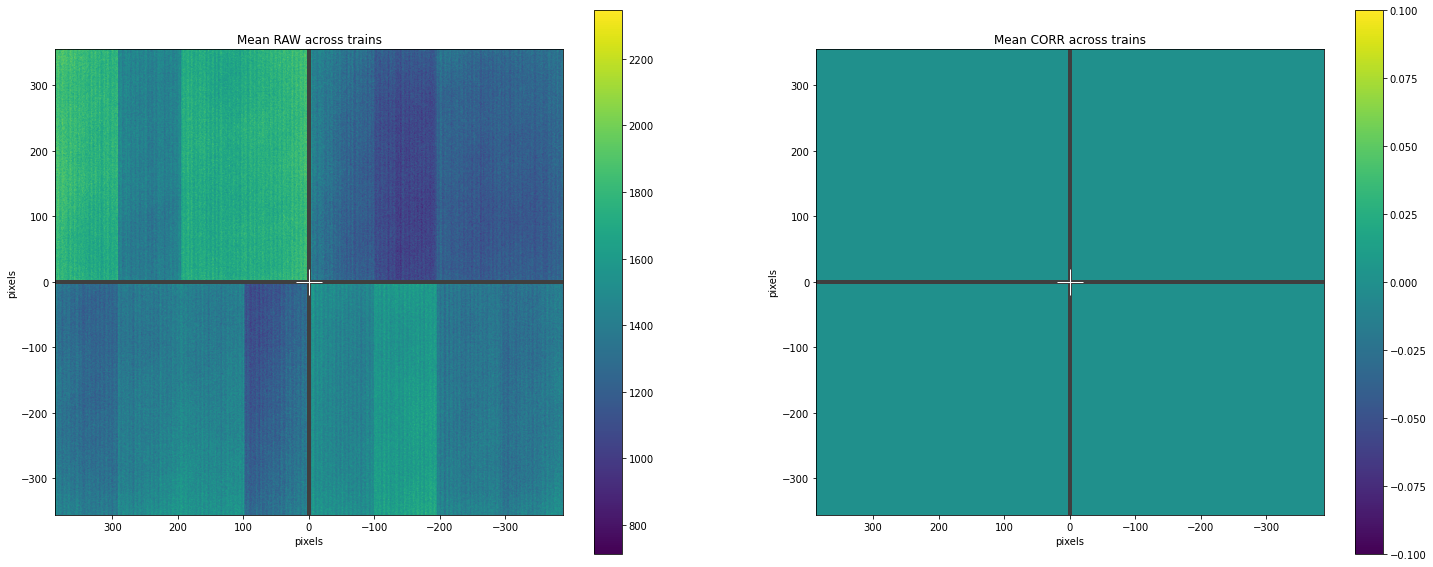

In [8]:
geom = Epix100Geometry.from_origin()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

# Plotting mean data for RAW and CORRECTED across trains
geom.plot_data(np.mean(raw_data, axis=0), ax=ax1)
ax1.set_title("Mean RAW across trains")
geom.plot_data(np.mean(corr_data, axis=0), ax=ax2)
ax2.set_title("Mean CORR across trains")

plt.show()